https://www.youtube.com/watch?v=D9yyt6BfgAM

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.txt to train.txt


# Data Cleaning

In [2]:
import pandas as pd
import numpy as np

In [3]:
file=pd.read_csv('train.txt', sep="\t") 
#file.head()
file=file.drop(columns='humor_rating')
file=file.drop(columns='humor_controversy')
file=file.drop(columns='offense_rating')
file=file.drop(columns='id')
print('File length',len(file))

File length 8000


#Data Transformation

In [4]:
from sklearn.preprocessing import LabelEncoder

file['labels']=LabelEncoder().fit_transform(file['is_humor'])
file=file.drop(columns='is_humor')

file['text'] = file['text'].values.tolist()
file['labels'] = file['labels'].values.tolist()

Libraries

In [5]:
!pip3 install tensorflow_text

     |████████████████████████████████| 4.9 MB 6.6 MB/s 


In [6]:
import tensorflow as tf
import tensorflow_hub as humor_controversy
import tensorflow_text as text

## is the dataset balanced?

In [7]:
file.groupby('labels').describe()

text                                                               
       count unique                                                top freq
labels                                                                     
0       3068   3068  I will never forgive anyone who voted for him ...    1
1       4932   4932  'Tis the season to start sentences with apostr...    1

#Split train test

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

xtrain, xremaining, ytrain, yremaining = train_test_split(file['text'],file['labels'], train_size=0.6, stratify= file['labels'])
xval, xtest, yval, ytest = train_test_split(xremaining, yremaining, test_size=0.5)


In [9]:
import tensorflow_hub as hub

In [10]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

Functional model, check video at min 11

In [11]:
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')

preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

model = tf.keras.Model(inputs=[text_input], outputs=[l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [21]:
tf.random.set_seed(11)


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(xtrain,
                    ytrain, 
                    epochs=6,
                    batch_size=64,
                    validation_data=(xval, yval))

Epoch 1/6
75/75 [==============================] - 132s 2s/step - loss: 0.4238 - acc: 0.8252 - val_loss: 0.4257 - val_acc: 0.8012
Epoch 2/6
75/75 [==============================] - 125s 2s/step - loss: 0.4085 - acc: 0.8365 - val_loss: 0.3843 - val_acc: 0.8475
Epoch 3/6
75/75 [==============================] - 125s 2s/step - loss: 0.4052 - acc: 0.8269 - val_loss: 0.3784 - val_acc: 0.8669
Epoch 4/6
75/75 [==============================] - 125s 2s/step - loss: 0.3963 - acc: 0.8394 - val_loss: 0.3640 - val_acc: 0.8606
Epoch 5/6
75/75 [==============================] - 125s 2s/step - loss: 0.3911 - acc: 0.8408 - val_loss: 0.3492 - val_acc: 0.8744
Epoch 6/6
75/75 [==============================] - 141s 2s/step - loss: 0.3819 - acc: 0.8452 - val_loss: 0.3420 - val_acc: 0.8794


#Plots

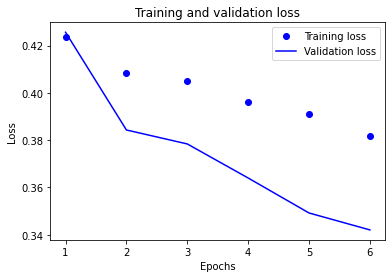

In [22]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc = history_dict['acc'] # is this line missing from the book by mistake? check

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

the optimal numer of epochs is around 6, 
check https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/

#Plotting training and validation accuracy p 75

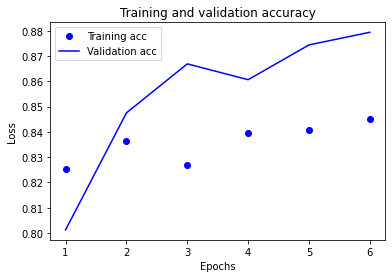

In [23]:
plt.clf()
acc_values = history_dict['acc']

val_acc = history_dict['val_acc'] #CHECK THE CORRECTION. IN THE BOOK THERE MUST BE A MISTAKE

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Test the model on the testset: BECAUSE THE OPTIMAL NUMBER OF EPOCHS SEEMS TO BE 6 WE TEST THE MODEL ON THE TEST SET WITH 6

In [25]:
tf.random.set_seed(11)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(xtrain,
                    ytrain, 
                    epochs=6,
                    batch_size=64,
                    validation_data=(xtest, ytest))

Epoch 1/6
75/75 [==============================] - 133s 2s/step - loss: 0.3690 - acc: 0.8450 - val_loss: 0.3824 - val_acc: 0.8363
Epoch 2/6
75/75 [==============================] - 125s 2s/step - loss: 0.3648 - acc: 0.8548 - val_loss: 0.3603 - val_acc: 0.8544
Epoch 3/6
75/75 [==============================] - 125s 2s/step - loss: 0.3659 - acc: 0.8462 - val_loss: 0.3715 - val_acc: 0.8631
Epoch 4/6
75/75 [==============================] - 124s 2s/step - loss: 0.3611 - acc: 0.8542 - val_loss: 0.3513 - val_acc: 0.8569
Epoch 5/6
75/75 [==============================] - 134s 2s/step - loss: 0.3607 - acc: 0.8525 - val_loss: 0.3466 - val_acc: 0.8675
Epoch 6/6
75/75 [==============================] - 135s 2s/step - loss: 0.3542 - acc: 0.8573 - val_loss: 0.3465 - val_acc: 0.8737


In [26]:
model.evaluate(xtest, ytest)

50/50 [==============================] - 31s 601ms/step - loss: 0.3465 - acc: 0.8737


[0.3464536666870117, 0.8737499713897705]

In [27]:
model

# Calculate the metrics


code from https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
tf.random.set_seed(11) 

# predict probabilities for test set
yhat_probs = model.predict(xtest, verbose=0)

# predict crisp classes for test set
yhat_classes = model.predict(xtest, verbose=0)
yhat_classes = np.where(yhat_classes > 0.5, 1, 0)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(ytest, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest, yhat_classes)
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(ytest, yhat_classes)
print(matrix)

Accuracy: 0.873750
Precision: 0.892233
Recall: 0.909901
F1 score: 0.900980
[[479 111]
 [ 91 919]]
